# Introduction
This notebook illustrates the motion of an electron into a rectangular waveguide.

# References
 * Semenov et al., Multipactor in Rectangular Waveguides, Physics of Plasmas 14, 033501 (2007).

In [16]:
# Python modules import
%pylab
%matplotlib inline
import numpy as np # numpy
from scipy.constants import c, pi, m_e, e, mu_0 # some physical constants

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\JH218595\Documents\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We consider here the fundamental mode TE10 in a rectangular waveguide of width $a$ ($-a/2<x<a/2$) and height $b$ ($0<y<b$):
$$
\begin{array}{ccl}
 E_y &=& -E_0 \cos(k_\perp x) \sin(\omega t - k z) \\
 H_x &=& \frac{c k}{\omega} E_0 \cos(k_\perp x) \sin(\omega t - k z) \\
 H_z &=& \frac{c k_\perp}{\omega} E_0 \sin(k_\perp x) \cos(\omega t - k z)
\end{array}
$$

In [17]:
def EH_field_rect_wg(x, z, t, f, E0, a):
    """
    Returns the E and H field component of the TE10 mode
    in a rectangular waveguide (a x b). 
    x being defined as [-a/2,a/2] and y in [0,b]
    
    Inputs:
     - x, z, t : spatial and time coordinates
     - f: frequency in [Hz]
     - E0: Electric field amplitude in [V/m]
     - a: waveguide width [m]
     
    Returns: 
     - Ey, Hx, Hz 
    """
    k_perp = pi/a
    omega = 2*pi*f
    k = np.sqrt((omega/c)**2 - k_perp**2)
    Ey = -E0*np.cos(k_perp*x)*np.sin(omega*t - k*z)
    Hx = c*k/omega*E0*np.cos(k_perp*x)*np.sin(omega*t - k*z)
    Hz = c*k_perp/omega*E0*np.sin(k_perp*x)*np.cos(omega*t - k*z)
    
    return Ey, Hx, Hz

The motion of the electron inside the waveguide is given by $m\ddot{\mathbf{x}}=q(\mathbf{E} + \dot{\mathbf{x}}\times\mathbf{B})$, i.e.:
$$
\begin{array}{ccl}
     m \ddot{y} &=& -e E_y - e H_x \dot{z}/c + e H_z \dot{x}/c \\
     m \ddot{x} &=& -e H_z \dot{y}/c \\
     m \ddot{z} &=& e H_x \dot{y}/c
\end{array}
$$

The previous system is rewritten with only first time derivatives system $\frac{d \mathbf{u}}{dt}=\mathbf{f}(\mathbf{u},t)$, with:
$$
\mathbf{u} = 
\left(
\begin{array}{c}
    x \\ y \\ z \\ \dot{x} \\ \dot{y} \\ \dot{z} 
\end{array}
\right)
$$
and
$$
\mathbf{f} =
\left(
\begin{array}{c}
    \dot{x} \\ \dot{y} \\ \dot{z} \\
    -\frac{e}{m c} H_z \dot{y} \\
    -\frac{e}{m} E_y - \frac{e}{m c} H_x \dot{z} + \frac{e}{m c} H_z \dot{x} \\
    \frac{e}{m c} H_x \dot{y}
\end{array}
\right)
$$

In [18]:
def fun(u, t, f, E0, a):
    """
    Computes the derivatives f(u,t).
    
    Inputs:
     - u: (x,y,z,xdot,ydot,zdot) (6x1 array)
     - t: time [s]
     - E0: Electric field amplitude [V/m]
     - a: rectangular waveguide width [m]
    
    Returns:
     - f(u,t) (6x1 array)
    
    """
    x, y, z, xdot, ydot, zdot = u # unpacking
    
    Ey, Hx, Hz = EH_field_rect_wg(x, z, t, f, E0, a)

    # Additional DC field along y
    H0 = 0/mu_0

    f = [xdot, 
         ydot, 
         zdot, 
         -e/(m_e*c)*Hz*ydot + e/(m_e*c)*H0*zdot, 
         -e/m_e*Ey - e/(m_e*c)*Hx*zdot + e/(m_e*c)*Hz*xdot, 
         e/(m_e*c)*Hx*ydot - e/(m_e*c)*H0*xdot]
    
    return f

In [19]:
# Constants
a = 72e-3
b = 34e-3
f = 3.7e9
E0 = 1e5
t = linspace(0e-9, 200/f, 501) # time range to solve : 200 RF periods

In [20]:
from scipy.integrate import odeint

# electron initial location
x0, y0, z0 = [-a/8, 0, 0]
# electron initial velocity
vx0, vy0, vz0 = [0, 0, 0]

# initial condition
u0 = [x0, y0, z0, vx0, vy0, vz0]
# solve 
u_num = odeint(fun, u0, t, args=(f, E0, a))

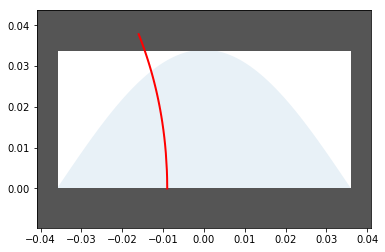

In [21]:
# plot the (x(t), y(t)) motion of the electron in the waveguide cross section
plot(u_num[:,0], u_num[:,1], color='r', lw=2)
# superpose the Efield
x = linspace(-a/2, a/2, 101)
fill_between(x, b*cos(pi/a*x), alpha=0.1)
# shade the waveguide walls for illustration
axis('equal')
axis([-a/2-5e-3, +a/2+5e-3, 0-5e-3, b+5e-3])
axhspan(ymin=0-10e-3, ymax=0, color='#555555')
axhspan(ymin=b, ymax=b+10e-3, color='#555555')
axvspan(xmin=-a/2-10e-3, xmax=-a/2, color='#555555')
axvspan(xmin=+a/2, xmax=a/2+10e-3, color='#555555')

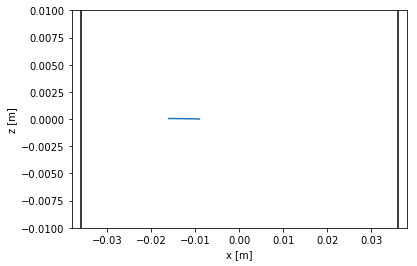

In [22]:
# (x,z) plot
plot(u_num[:,0], u_num[:,2])
axis([-a/2-2e-3, a/2+2e-3, -10e-3, +10e-3], 'equal')
axvline(-a/2, color='k')
axvline(+a/2, color='k')
xlabel('x [m]')
ylabel('z [m]')

In order to illustrate the motion for different starting point, we solve for many starting points and plot the result.

In [23]:
x0_vec = linspace(-a/2, a/2, 11)
u_num_vec = []

for x0 in x0_vec:
    # initial condition
    u0 = [x0, y0, z0, vx0, vy0, vz0]
    # solve 
    u_num_vec.append(odeint(fun, u0, t, args=(f, E0, a)))

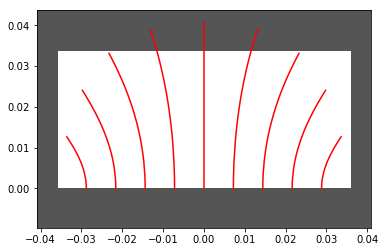

In [24]:
for u_num in u_num_vec:
    plot(u_num[:,0], u_num[:,1], color='r')
    
# shade the waveguide walls for illustration
axis('equal')
axis([-a/2-5e-3, +a/2+5e-3, 0-5e-3, b+5e-3])
axhspan(ymin=0-10e-3, ymax=0, color='#555555')
axhspan(ymin=b, ymax=b+10e-3, color='#555555')
axvspan(xmin=-a/2-10e-3, xmax=-a/2, color='#555555')
axvspan(xmin=+a/2, xmax=a/2+10e-3, color='#555555')    

In order to be resonant with the wall height $b$, a particle of velocity $V$ must travel a distance $\approx b$ (if one neglects the RF magnetic field in this case) during a half RF-period $T/2=1/(2f)=\pi/\omega$. More generally, it can be a odd number of (half-period) : 1, 3, 5... 
Thus, the resonance coundition is expressed as :
$$
b \approx V j / (2 f)
$$
thus
$$
b \omega \approx V j \pi
$$

The particle velocity is the addition of its initial emission velocity $V_{y0}$ (if emitted only in the normal direction) and the RF kick, given by : 
$$
V_{RF} \approx \frac{e E_y}{m \omega}
$$
again in the parallel plate approximation.